# Transfer the model trained in MNIST datasets to EMNIST datasets
### Difference between MNIST and EMNIST:
MNIST consists of 0-9 numbers, while EMNIST contains an additional 26 English letters. 
I have saved a model trained by MNIST datasets, and in this notebook I load it and keep its convolutional layers' parameters constant. I just train the last linear layer and change its output size into 26 which matches the number of classes(26 English letters).

In [1]:
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.5,],std=[0.5,])])

data_train=datasets.EMNIST(root='data/',split = 'letters', transform=transform,train=True,download=True)
data_test=datasets.EMNIST(root='data/',split = 'letters',transform=transform,train=False)

D:\anaconda\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
data_loader_train = torch.utils.data.DataLoader(data_train, batch_size = 64, shuffle = True)
data_loader_test = torch.utils.data.DataLoader(data_test, batch_size = 64, shuffle = True)

torch.Size([64, 1, 28, 28])
torch.Size([3, 242, 242])
after transpose shape: (242, 242, 3)
[tensor(25), tensor(22), tensor(14), tensor(8), tensor(18), tensor(13), tensor(14), tensor(1), tensor(18), tensor(26), tensor(21), tensor(9), tensor(5), tensor(18), tensor(15), tensor(13)]
[tensor(25), tensor(22), tensor(14), tensor(8), tensor(18), tensor(13), tensor(14), tensor(1), tensor(18), tensor(26), tensor(21), tensor(9), tensor(5), tensor(18), tensor(15), tensor(13)]
tensor(26)
tensor(1)


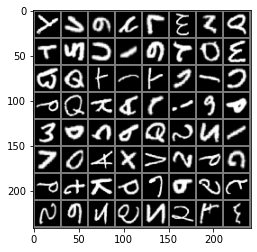

In [4]:
images,labels=next(iter(data_loader_train))
# Splicing the 64 pictures into one picture to see what the pictures look like
print(images.shape)
img=torchvision.utils.make_grid(images)
print(img.shape)
# transpose the img because imshow need a img construction of (height,weight,channel) 
# but img has a construction of (channel,height,weight)

img=img.numpy().transpose(1,2,0)

print("after transpose shape:",img.shape)
# Gray stretch
std = [0.5,0.5,0.5]
mean = [0.5,0.5,0.5]
img = img*std+mean
print([labels[i].data for i in range(16)])


print([labels[i].data for i in range(16)])
print(labels.data.max())
print(labels.data.min())
plt.imshow(img)
plt.show()


In [5]:
# origin shape of image is (1,28,28)
class CNN_Net(torch.nn.Module):
    def __init__(self):
        super(CNN_Net, self).__init__()
        self.conv1 = torch.nn.Sequential(
            # Convolution change to (64,28,28)
            torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            # Maxpooling change to (64,14,14)
            torch.nn.MaxPool2d(stride=2,kernel_size=2))
        self.conv2=torch.nn.Sequential(
            # Convolution change to (128,14,14)
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            # Maxpooling change to (128,7,7)
            torch.nn.MaxPool2d(stride=2, kernel_size=2))
        self.dense = torch.nn.Sequential(
            torch.nn.Linear(128 * 7 * 7, 1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(1024, 10))

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        # change the size to one column to match the linear layer
        x = x2.view(-1, 128 * 7 * 7)
        x = self.dense(x)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
CNN_NET = torch.load('data/cnn_by_MNIST.pt')
cnn_net = CNN_NET
print(cnn_net)

CNN_Net(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (0): Linear(in_features=6272, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [12]:
for param in cnn_net.parameters():
    param.requires_grad = False

In [13]:
cnn_net.dense[3] = torch.nn.Linear(1024, 26)
for param in cnn_net.dense[3].parameters():

    param.requires_grad = True

In [14]:

# use GPU to accelerate
if torch.cuda.is_available():
    cnn_net = cnn_net.cuda()

# CrossEntropy = softmax + log + NLL loss

loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(cnn_net.dense[3].parameters(),lr=0.001)

def train():
    for data in data_loader_train:
        x_train, y_train = data
        t = torch.tensor(1)
        y_train = y_train -t
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        y_hat = cnn_net(x_train)
        loss = loss_func(y_hat, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch %d, loss %.4f' % (epoch + 1, loss))
    return loss  

In [15]:
def test():
    correct = 0
    for data in data_loader_test:
        x_test, y_test = data
        t = torch.tensor(1)
        y_test = y_test -t
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        with torch.no_grad():
            outputs = cnn_net(x_test)
        
        _, predict = torch.max(outputs.data, dim=1)
        correct += torch.sum(predict == y_test.data)
    correct = correct.detach().cpu().numpy()
    print("correct rate = ",100 * correct/len(data_test))
    return 100 * correct/len(data_test) *0.01

epoch 1, loss 0.7973
correct rate =  74.77403846153847
epoch 2, loss 1.1351
correct rate =  74.35096153846153
epoch 3, loss 0.7301
correct rate =  74.42788461538461
epoch 4, loss 0.7290
correct rate =  74.30288461538461
epoch 5, loss 0.9707
correct rate =  74.28365384615384
epoch 6, loss 0.9165
correct rate =  74.58653846153847
epoch 7, loss 0.8504
correct rate =  74.28846153846153
epoch 8, loss 0.5933
correct rate =  74.0576923076923
epoch 9, loss 0.7594
correct rate =  74.22596153846153
epoch 10, loss 0.7684
correct rate =  74.36538461538461


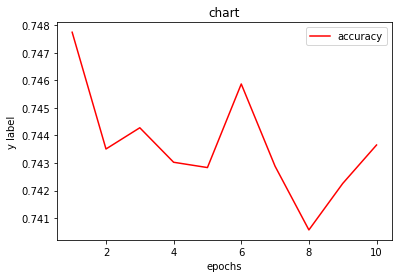

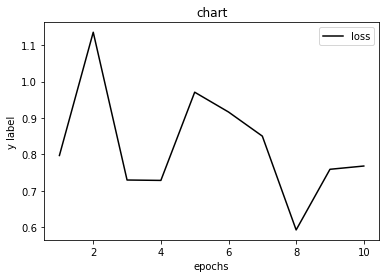

In [17]:
lss = []
acc = []
epochs = []
for epoch in range(10):
    epochs.append(epoch+1)
    ls = train();
    ac = test();
    l_tmp = ls.detach().cpu().numpy()
    lss.append(l_tmp)
    acc.append(ac);
    
plt.plot(epochs,acc,color='r',label='accuracy')  
plt.xlabel('epochs')    
plt.ylabel('y label')   
plt.title("chart")      
plt.legend()   
plt.show()

plt.plot(epochs,lss,color=(0,0,0),label='loss')
plt.xlabel('epochs')    
plt.ylabel('y label')   
plt.title("chart")      
plt.legend()            
plt.show()